# Análisis de sentimientos de tweets en aerolíneas de Estados Unidos


### Carga de librerías y *dataset*

In [ ]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carga del archivo .CSV

In [ ]:
# Ruta del archivo en tu Google Drive
file_path = '/content/drive/MyDrive/UAM/UTB/DataScience/TweetsAirline.csv'

# Cargar el archivo en un DataFrame
df = pd.read_csv(file_path)
print("Shape original:", df.shape)
df.head()


Shape original: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Instalación de librerías y recursos necesarios para manipular correctamente el **dataset**

### Instalación de librería NLTK (Natural Language Toolkit)

In [ ]:
!pip install nltk --quiet


### Descarga de recursos esenciales desde NLTK:
- stopwords: lista de palabras comunes (como "the", "is", "in") que no aportan mucho significado.
- wordnet: base de datos léxica del inglés, usada para lematización.
- punkt: modelo de tokenización (separa el texto en palabras).
- omw-1.4: datos adicionales multilingües para la lematización con WordNet.


In [ ]:
!python -m nltk.downloader stopwords wordnet punkt omw-1.4

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Importación de módulos de NLTK

In [ ]:
import re
import nltk
from nltk.corpus import stopwords          # Sirve para obtener las stopwords en inglés
from nltk.tokenize import word_tokenize    # Sirve para dividir el texto en palabras individuales
from nltk.stem import WordNetLemmatizer    # Sirve para convertir las palabras a su forma base o raíz
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Limpieza del dataset

In [ ]:
# Se seleccionan solo las columnas con las que trabajaremos
df = df[['tweet_id', 'airline', 'retweet_count', 'text', 'tweet_created']]
print("Shape después de eliminar columnas:", df.shape)
df.head()

Shape después de eliminar columnas: (14640, 5)


,tweet_id,airline,retweet_count,text,tweet_created
0,570306133677760513,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,570301083672813571,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,570301031407624196,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,570300817074462722,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


In [ ]:
# Creamos un conjunto de "stop words" en inglés.
# Estas son palabras comunes que generalmente se eliminan porque no aportan mucho significado al análisis (como: 'the', 'and', 'but').
stop_words = set(stopwords.words('english'))

print(stop_words)
# Inicializamos el lematizador WordNet.
# La lematización transforma una palabra a su forma raíz (por ejemplo: "running" → "run") conservando el significado.
lemmatizer = WordNetLemmatizer()

{"haven't", "i'd", 'we', 'yourself', 'against', 'when', 'does', 'been', 'should', 'that', 'is', 'no', 'and', "she'd", 'y', "we'll", 'more', 'further', 'i', 'mightn', "he's", "they're", 'm', 'you', 'they', 'their', "hadn't", 'but', 'mustn', 'has', 'why', 'didn', 'itself', 'so', "wasn't", "you're", 'him', 'other', 'the', 'ourselves', 'won', 'his', "it'd", 'yours', 'once', 'her', 'such', 'them', "they'll", 'or', 'all', "didn't", 'again', 'through', 'very', 'than', 'above', 'any', 'as', 'he', "they've", 'weren', 'couldn', 'from', 'by', 'd', "should've", "you'll", 'wasn', "that'll", 'have', "it's", "we've", 'too', 'these', 'herself', 'it', "mightn't", 'myself', "shouldn't", 'not', 'ma', "doesn't", 'hadn', 'don', 'ours', "he'd", 'o', "couldn't", 'down', 'this', 'until', 'between', 'about', "hasn't", 'now', 'himself', 'those', 'same', 'being', 'ain', 'most', 'nor', "needn't", 'll', 'while', 'its', 'off', 'for', 'during', "i'm", 'needn', "aren't", 'out', "he'll", "i've", "we're", 'whom', 'if',

In [ ]:
# Función para limpiar y lematizar texto
def preprocess_text(text):
    # 1. Pasar a minúsculas para estandarizar
    text = text.lower()

    # 2. Eliminar URLs (http, https y www)
    text = re.sub(r'http\S+|www.\S+', '', text)

    # 3. Eliminar menciones (@usuario) y hashtags (#hashtag)
    text = re.sub(r'@\w+|#\w+', '', text)

    # 4. Eliminar signos de puntuación y caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Eliminar espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenizar (convertir el texto en una lista de palabras individuales)
    tokens = word_tokenize(text)

    # 7. Eliminar stop words y aplicar lematización
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]

    # 8. Unir las palabras limpias en una sola cadena
    return ' '.join(cleaned_tokens)


### Aplicar función a la columna "text" del dataset

In [ ]:
# Aplicar preprocesamiento al dataset
df['clean_text'] = df['text'].apply(preprocess_text)

# Ver los primeros resultados comparando texto original y limpio
df[['text', 'clean_text']].head()


,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


## Instalación y uso del modelo VADER

In [ ]:
!pip install vaderSentiment --quiet

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar el analizador
analyzer = SentimentIntensityAnalyzer()

Usamos la librería vaderSentiment, que ofrece un analizador preentrenado para texto informal.

A cada texto limpio (clean_text) se le aplica polarity_scores, que devuelve cuatro valores (neg, neu, pos, compound).

Nos quedamos con compound, una puntuación entre -1 y 1.

Si

compound >= 0.05 → positivo

compound <= -0.05 → negativo

entre ambos → neutral

In [ ]:
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Aplicar análisis de sentimiento
df['compound_score'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment'] = df['compound_score'].apply(get_sentiment_label)


In [ ]:
df[['clean_text','text','compound_score','sentiment',]].head(10)


,clean_text,text,compound_score,sentiment
0,said,@VirginAmerica What @dhepburn said.,0.0000,neutral
1,plus youve added commercial experience tacky,@VirginAmerica plus you've added commercials t...,0.0000,neutral
2,didnt today must mean need take another trip,@VirginAmerica I didn't today... Must mean I n...,0.0000,neutral
3,really aggressive blast obnoxious entertainmen...,@VirginAmerica it's really aggressive to blast...,-0.3306,negative
4,really big bad thing,@VirginAmerica and it's a really big bad thing...,-0.5829,negative
5,seriously would pay flight seat didnt playing ...,@VirginAmerica seriously would pay $30 a fligh...,0.0963,positive
6,yes nearly every time fly vx ear worm wont go ...,"@VirginAmerica yes, nearly every time I fly VX...",0.4019,positive
7,really missed prime opportunity men without ha...,@VirginAmerica Really missed a prime opportuni...,0.1458,positive
8,well didntbut,"@virginamerica Well, I didn't…but NOW I DO! :-D",0.2732,positive
9,amazing arrived hour early youre good,"@VirginAmerica it was amazing, and arrived an ...",0.7717,positive


# Estadísticas agregadas

In [ ]:
import pandas as pd

# Porcentaje por categoría de sentimiento
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
print("Porcentaje por sentimiento:")
print(sentiment_counts)

# Promedio de compound score por categoría
avg_scores = df.groupby('sentiment')['compound_score'].mean()
print("\nPuntuación compuesta promedio por sentimiento:")
print(avg_scores)


Porcentaje por sentimiento:
sentiment
positive    44.098361
negative    30.034153
neutral     25.867486
Name: proportion, dtype: float64

Puntuación compuesta promedio por sentimiento:
sentiment
negative   -0.417861
neutral     0.000534
positive    0.473616
Name: compound_score, dtype: float64


<ipython-input-41-4cd45731c89b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="pastel")


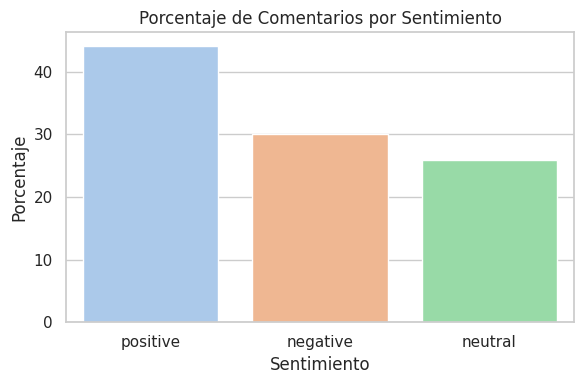

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo bonito
sns.set(style="whitegrid")

# Gráfico de barras del porcentaje
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="pastel")
plt.title("Porcentaje de Comentarios por Sentimiento")
plt.ylabel("Porcentaje")
plt.xlabel("Sentimiento")
plt.tight_layout()
plt.savefig("grafico_porcentaje_sentimiento.png")  # Si quieres guardar
plt.show()


In [ ]:
!pip install wordcloud --quiet


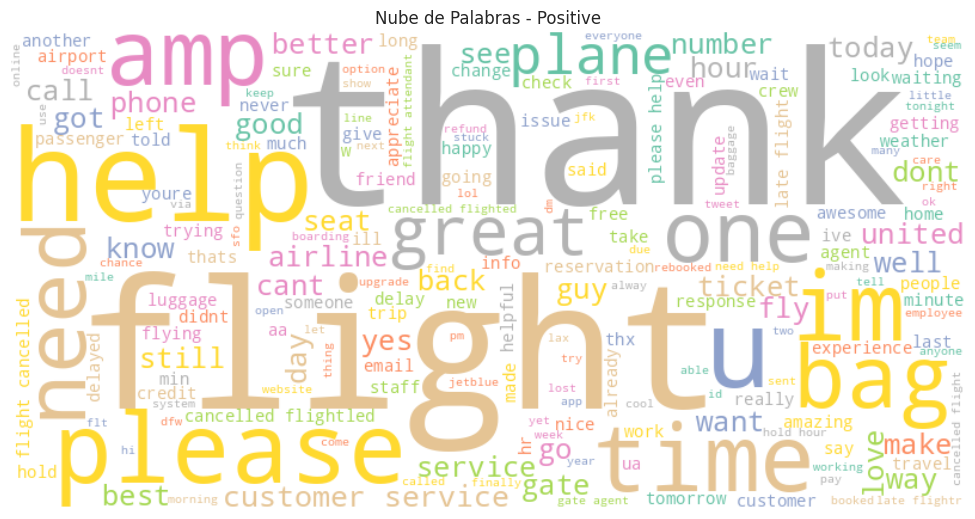

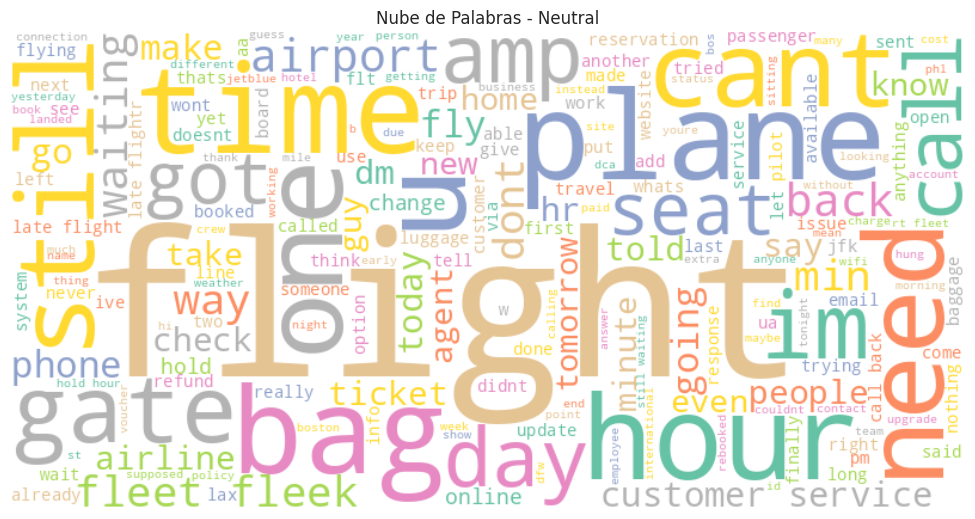

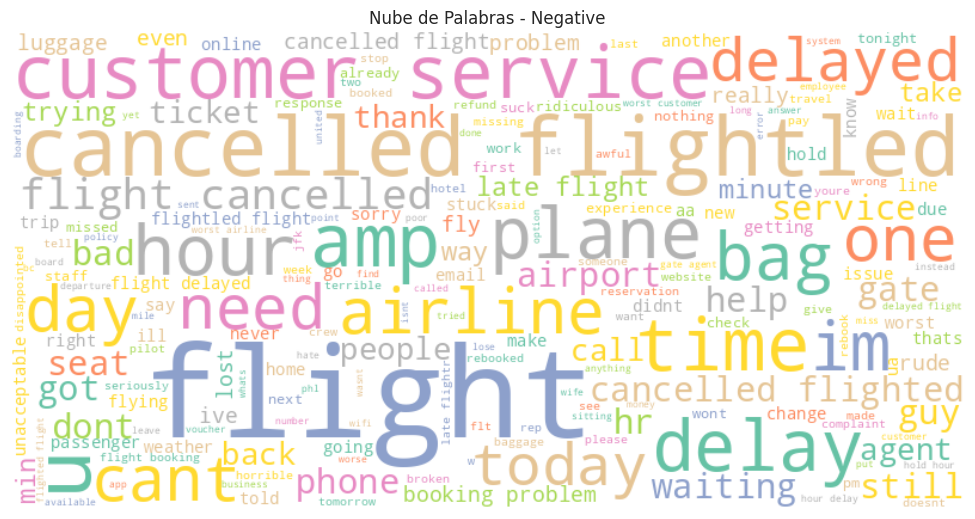

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear nubes de palabras por cada sentimiento
for sentiment in ['positive', 'neutral', 'negative']:
    # Unimos todos los textos en uno solo
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'])

    # Crear la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate(text)

    # Mostrar la nube
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras - {sentiment.capitalize()}')
    plt.tight_layout(pad=0)

    # Guardar la imagen si lo deseas
    plt.savefig(f"wordcloud_{sentiment}.png")
    plt.show()


<Figure size 1200x600 with 0 Axes>

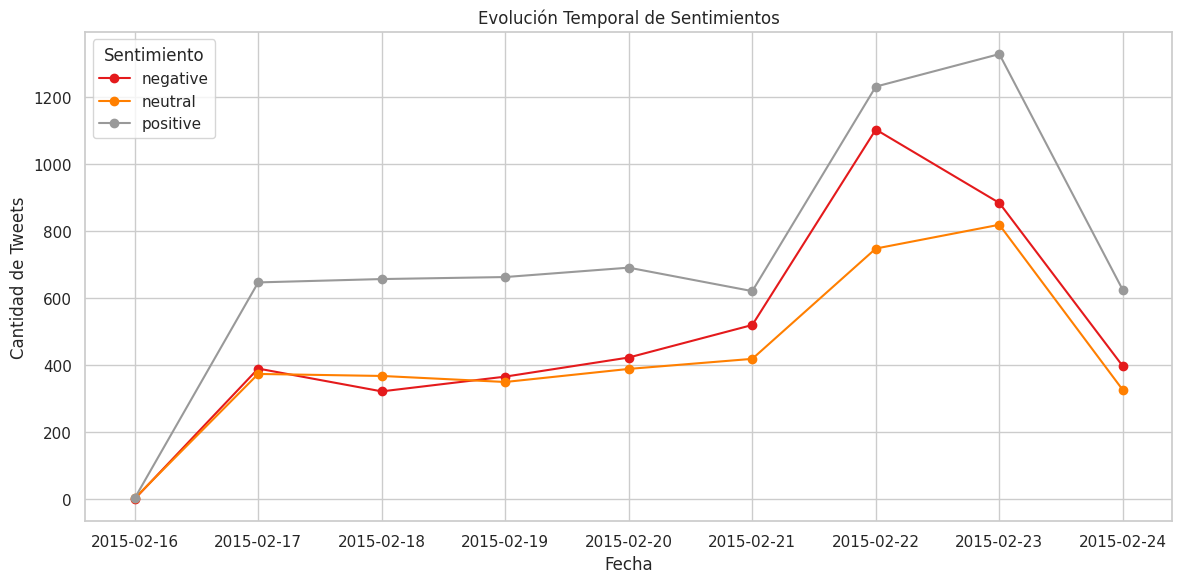

In [ ]:
# Convertir a datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

# Extraer solo la fecha (sin hora)
df['tweet_date'] = df['tweet_created'].dt.date


# Agrupar por fecha y sentimiento
daily_sentiment = df.groupby(['tweet_date', 'sentiment']).size().unstack().fillna(0)

# Gráfico de línea para series temporales
plt.figure(figsize=(12, 6))
daily_sentiment.plot(kind='line', figsize=(12, 6), marker='o', colormap='Set1')

plt.title('Evolución Temporal de Sentimientos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Tweets')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Sentimiento')
plt.savefig("serie_temporal_sentimientos.png")
plt.show()


## Exportar en JSON para posteriormente cargar en WEB


In [ ]:
import json
from collections import defaultdict


In [ ]:
# Cargar tweets
tweets_data = df[['tweet_id', 'clean_text', 'sentiment', 'tweet_created']].copy()
tweets_data['tweet_created'] = tweets_data['tweet_created'].astype(str)  # Convertir datetime a string
tweets_list = tweets_data.to_dict(orient='records')

In [ ]:
# Cargar summary

# Conteos
sentiment_counts = df['sentiment'].value_counts().to_dict()

# Porcentajes
total = len(df)
sentiment_percentages = {k: round(v / total * 100, 2) for k, v in sentiment_counts.items()}

summary_data = {
    "count": sentiment_counts,
    "percentage": sentiment_percentages
}
print(summary_data)

{'count': {'positive': 6456, 'negative': 4397, 'neutral': 3787}, 'percentage': {'positive': 44.1, 'negative': 30.03, 'neutral': 25.87}}


In [ ]:
wordclouds_data = {
    "positive": "wordcloud_positive.png",
    "neutral": "wordcloud_neutral.png",
    "negative": "wordcloud_negative.png"
}


In [ ]:
bar_chart_data = [
    {"sentiment": k, "count": v, "percentage": sentiment_percentages[k]}
    for k, v in sentiment_counts.items()
]

timeline_data = []

# daily_sentiment viene del paso anterior
for date, row in daily_sentiment.iterrows():
    timeline_data.append({
        "date": str(date),
        "positive": int(row.get("positive", 0)),
        "neutral": int(row.get("neutral", 0)),
        "negative": int(row.get("negative", 0))
    })


In [ ]:
final_data = {
    "tweets": tweets_list,
    "summary": summary_data,
    "bar_chart": bar_chart_data,
    "wordclouds": wordclouds_data,
    "timeline": timeline_data
}

# Guardar a JSON
with open("sentiment_results.json", "w", encoding='utf-8') as f:
    json.dump(final_data, f, indent=2, ensure_ascii=False)
